In [1]:
# If running from visualize/ folder, go to project root:
import os, pathlib, sys
ROOT = pathlib.Path(__file__).resolve().parents[1] if "__file__" in globals() else pathlib.Path.cwd().parents[0]
os.chdir(ROOT)
sys.path.append(str(ROOT))

print("Project root:", os.getcwd())

import torch, numpy as np, matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision import transforms

from cifar100_data import CIFAR100Config, get_cifar100_dataloaders, build_transforms
from models.mobilenetv3 import build_mobilenetv3_small
from attacks.fgsm import fgsm_attack
from utils.norm import to_hard


Project root: c:\Users\Trieu\Documents\Code\Code\Adversarial Training\adv_mnv3_cifar100


c:\Users\Trieu\miniconda3\envs\cifar100\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model init and utility functions

In [2]:
RUN_DIR = pathlib.Path("./runs_mnv3")
BASELINE_CKPT = RUN_DIR / "mobilenetv3_cifar100_baseline.pt"
ADV_CKPT      = RUN_DIR / "mobilenetv3_cifar100_advtrained.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


In [3]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])[None, :, None, None]
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225])[None, :, None, None]

def denorm(x: torch.Tensor):
    if x.ndim == 3: x = x.unsqueeze(0)
    x = x * IMAGENET_STD.to(x.device) + IMAGENET_MEAN.to(x.device)
    return x.clamp(0,1)

def show_grid(tensor, nrow=8, title=None):
    grid = make_grid(tensor, nrow=nrow)
    plt.figure(figsize=(nrow*1.5, 1.5*(len(tensor)//nrow + 1)))
    plt.imshow(grid.permute(1,2,0).cpu().numpy())
    plt.axis("off")
    if title: plt.title(title)
    plt.show()

In [4]:
# Use the same config as training
cfg = CIFAR100Config()
train_loader, _, test_loader = get_cifar100_dataloaders(cfg)

def load_model(ckpt_path):
    m = build_mobilenetv3_small(num_classes=100, pretrained=True).to(device)
    state = torch.load(ckpt_path, map_location=device)
    m.load_state_dict(state, strict=False)
    m.eval()
    return m

baseline = load_model(BASELINE_CKPT)
adv_model = load_model(ADV_CKPT)

# CIFAR-100 dataset samples

In [5]:
from collections import Counter
from torchvision.datasets import CIFAR100

# Use your same data_dir for reproducibility
train_raw = CIFAR100(root=cfg.data_dir, train=True, download=True)
test_raw  = CIFAR100(root=cfg.data_dir, train=False, download=True)

print("CIFAR-100 stats")
print("----------------")
print("Num classes:", len(train_raw.classes))
print("Train images:", len(train_raw))       # 50,000
print("Test images:", len(test_raw))         # 10,000
print("Per-class: 500 train + 100 test (600 total)")
print("\nClass names (100):")
print(", ".join(train_raw.classes))

CIFAR-100 stats
----------------
Num classes: 100
Train images: 50000
Test images: 10000
Per-class: 500 train + 100 test (600 total)

Class names (100):
apple, aquarium_fish, baby, bear, beaver, bed, bee, beetle, bicycle, bottle, bowl, boy, bridge, bus, butterfly, camel, can, castle, caterpillar, cattle, chair, chimpanzee, clock, cloud, cockroach, couch, crab, crocodile, cup, dinosaur, dolphin, elephant, flatfish, forest, fox, girl, hamster, house, kangaroo, keyboard, lamp, lawn_mower, leopard, lion, lizard, lobster, man, maple_tree, motorcycle, mountain, mouse, mushroom, oak_tree, orange, orchid, otter, palm_tree, pear, pickup_truck, pine_tree, plain, plate, poppy, porcupine, possum, rabbit, raccoon, ray, road, rocket, rose, sea, seal, shark, shrew, skunk, skyscraper, snail, snake, spider, squirrel, streetcar, sunflower, sweet_pepper, table, tank, telephone, television, tiger, tractor, train, trout, tulip, turtle, wardrobe, whale, willow_tree, wolf, woman, worm


In [6]:
def get_class_names_from_loader(loader):
    ds = loader.dataset
    # handle Subset(train_set, ...) or other wrappers
    if hasattr(ds, "classes"):
        return ds.classes
    if hasattr(ds, "dataset") and hasattr(ds.dataset, "classes"):
        return ds.dataset.classes
    raise AttributeError("Could not find .classes on loader.dataset")

classes = get_class_names_from_loader(test_loader)

c:\Users\Trieu\miniconda3\envs\cifar100\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


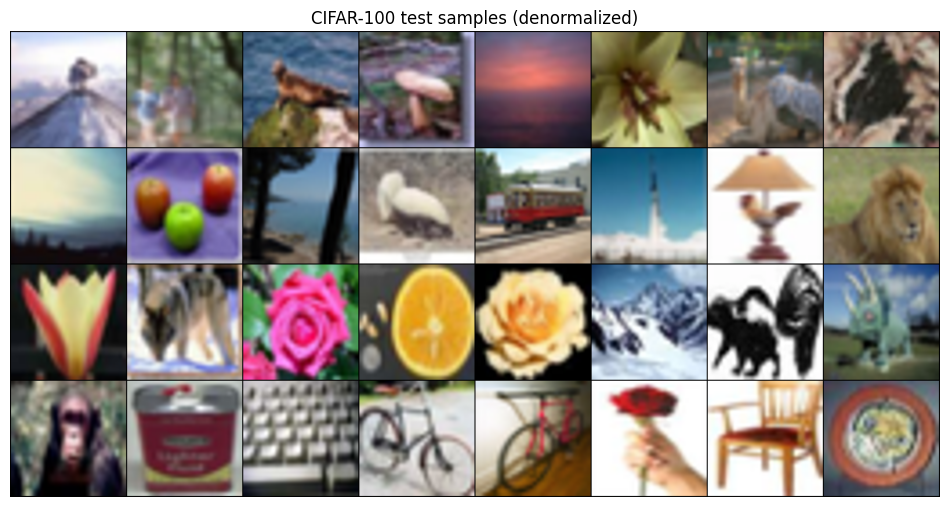

In [7]:
images, targets = next(iter(test_loader))
k = 32 
show_grid(denorm(images[:k]), nrow=8, title="CIFAR-100 test samples (denormalized)")

# Imgae Preprocessing

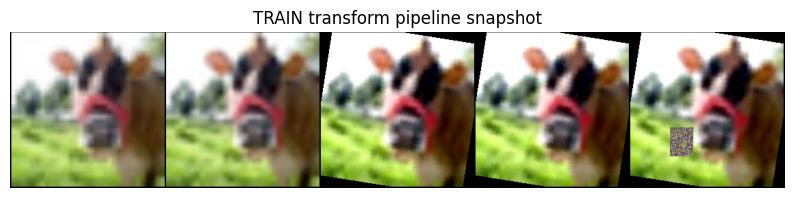

[train 1] original (32×32)
[train 2] resize 224
[train 3] randaugment N=2 M=9
[train 4] toTensor + normalize
[train 5] random erasing (forced for demo)


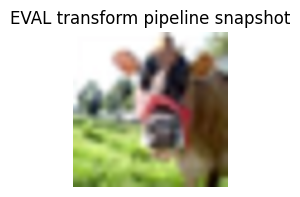

[eval 1] eval: toTensor + resize + normalize

Per-stage stats (train stages):
  - original (32×32)                  (PIL image)
  - resize 224                        (PIL image)
  - randaugment N=2 M=9               (PIL image)
  - toTensor + normalize              mean=0.181 std=1.493 min=-2.118 max=2.640
  - random erasing (forced for demo)  mean=0.155 std=1.487 min=-3.368 max=3.490
Saved: runs_mnv3\visuals\pipeline_train.png and runs_mnv3\visuals\pipeline_eval.png


In [8]:
# ---- Imports & seed (reproducible snapshot)
import random, numpy as np, torch
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image

random.seed(1337); np.random.seed(1337); torch.manual_seed(1337)

# ---- Rebuild train/eval tfms from your config
train_tfms, eval_tfms = build_transforms(cfg)

# ---- Load one raw PIL image (un-transformed)
from torchvision.datasets import CIFAR100
raw_ds = CIFAR100(root=cfg.data_dir, train=True, download=True)
pil_img, label = raw_ds[0]

# ---- Build a *train* snapshot, stage-by-stage (mirrors your pipeline)
train_stages = []
train_stages.append(("original (32×32)", pil_img))

resized = transforms.Resize(cfg.img_size, interpolation=InterpolationMode.BICUBIC)(pil_img)
train_stages.append((f"resize {cfg.img_size}", resized))

work_img = resized
if cfg.randaugment:
    ra = transforms.RandAugment(num_ops=cfg.randaugment_N, magnitude=cfg.randaugment_M)
    work_img = ra(work_img)
    train_stages.append((f"randaugment N={cfg.randaugment_N} M={cfg.randaugment_M}", work_img))

# ToTensor + Normalize
norm_img = transforms.Normalize(mean=cfg.mean, std=cfg.std)(transforms.ToTensor()(work_img))
train_stages.append(("toTensor + normalize", norm_img))

# (demo only) force-apply RandomErasing exactly once for visualization
if cfg.random_erasing_p > 0:
    re = transforms.RandomErasing(p=1.0, value='random')  # force apply for demo
    re_img = re(norm_img.clone())
    train_stages.append(("random erasing (forced for demo)", re_img))

# ---- Also show the *eval* pipeline on the same raw image
eval_img_tensor = eval_tfms(pil_img)     # tensor normalized
eval_stages = [
    ("eval: toTensor + resize + normalize", eval_img_tensor)
]

# ---- Helper to denorm and ensure same spatial size (224×224)
import matplotlib.pyplot as plt
IMAGENET_MEAN = torch.tensor(cfg.mean)[None, :, None, None]
IMAGENET_STD  = torch.tensor(cfg.std )[None, :, None, None]

def denorm(x: torch.Tensor):
    is_batched = (x.ndim == 4)
    if not is_batched: x = x.unsqueeze(0)
    x = x * IMAGENET_STD.to(x.device) + IMAGENET_MEAN.to(x.device)
    x = x.clamp(0,1)
    return x if is_batched else x[0]

def to_224_chw01(img):
    """Convert PIL or CHW tensor in [0,1]/normalized to CHW 224×224 [0,1] for display."""
    target_size = (cfg.img_size, cfg.img_size)
    if isinstance(img, torch.Tensor):
        # If normalized, bring to [0,1] for viewing
        t = denorm(img) if img.dtype.is_floating_point else img
        if t.ndim == 4: t = t[0]
    else:
        t = transforms.ToTensor()(img)
    if t.shape[-2:] != target_size:
        t = F.interpolate(t.unsqueeze(0), size=target_size, mode="bilinear", align_corners=False)[0]
    return t

# ---- Build grids for train & eval snapshots
train_tiles, train_labels = [], []
for name, img in train_stages:
    train_tiles.append(to_224_chw01(img).cpu())
    train_labels.append(name)

eval_tiles, eval_labels = [], []
for name, img in eval_stages:
    eval_tiles.append(to_224_chw01(img).cpu())
    eval_labels.append(name)

train_grid = make_grid(torch.stack(train_tiles), nrow=len(train_tiles))
eval_grid  = make_grid(torch.stack(eval_tiles),  nrow=len(eval_tiles))

# ---- Plot
plt.figure(figsize=(2*len(train_tiles), 2.2))
plt.imshow(train_grid.permute(1,2,0).numpy()); plt.axis("off")
plt.title("TRAIN transform pipeline snapshot")
plt.show()

for i, name in enumerate(train_labels, 1):
    print(f"[train {i}] {name}")

plt.figure(figsize=(2*len(eval_tiles), 2.2))
plt.imshow(eval_grid.permute(1,2,0).numpy()); plt.axis("off")
plt.title("EVAL transform pipeline snapshot")
plt.show()

for i, name in enumerate(eval_labels, 1):
    print(f"[eval {i}] {name}")

# ---- Per-stage stats (mean/std/min/max) to explain normalization in the report
def tensor_stats(x):
    x = x.detach().float()
    return dict(mean=float(x.mean()), std=float(x.std()), min=float(x.min()), max=float(x.max()))

print("\nPer-stage stats (train stages):")
for name, img in train_stages:
    if isinstance(img, torch.Tensor):
        # show stats for pre-denorm (true internal values)
        stats = tensor_stats(img)
        print(f"  - {name:32s}  mean={stats['mean']:.3f} std={stats['std']:.3f} "
              f"min={stats['min']:.3f} max={stats['max']:.3f}")
    else:
        print(f"  - {name:32s}  (PIL image)")

# ---- Save PNGs for the report
vis_dir = (RUN_DIR / "visuals"); vis_dir.mkdir(parents=True, exist_ok=True)
save_image(train_grid, vis_dir / "pipeline_train.png")
save_image(eval_grid,  vis_dir / "pipeline_eval.png")
print("Saved:", vis_dir / "pipeline_train.png", "and", vis_dir / "pipeline_eval.png")


# Baseline model vs Adversarial training model

In [9]:
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
from attacks.fgsm import fgsm_attack
from utils.norm import to_hard

# --- settings
eps = 2/255.0              # same epsilon as training/eval
kshow = 8                  # how many images to display
save_dir = (RUN_DIR / "visuals"); save_dir.mkdir(parents=True, exist_ok=True)

## ε-sweep montage (rows = ε, columns = images)

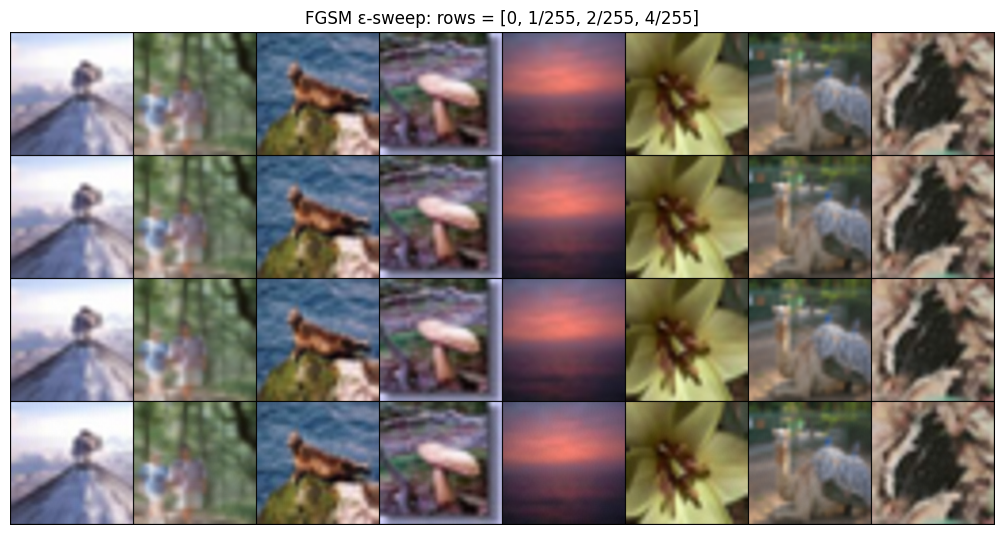

In [ ]:
eps_list = [0, 1/255, 2/255, 4/255]
images2, targets2 = next(iter(test_loader))
images2 = images2[:kshow].to(device)
targets2 = to_hard(targets2[:kshow]).to(device)

rows = []
for e in eps_list:
    img_e = images2 if e == 0 else fgsm_attack(baseline, images2, targets2, eps=e)
    rows.append(denorm(img_e).clamp(0,1).cpu())
big_grid = make_grid(torch.cat(rows, dim=0), nrow=kshow)
plt.figure(figsize=(1.6*kshow, 1.6*len(eps_list)))
plt.imshow(big_grid.permute(1,2,0).numpy()); plt.axis("off")
plt.title("FGSM ε-sweep: rows = [0, 1/255, 2/255, 4/255]")
plt.show()
save_image(big_grid, save_dir / "fgsm_eps_sweep.png")


## Adversarial samples: clean vs adv vs perturbation (+ predictions)

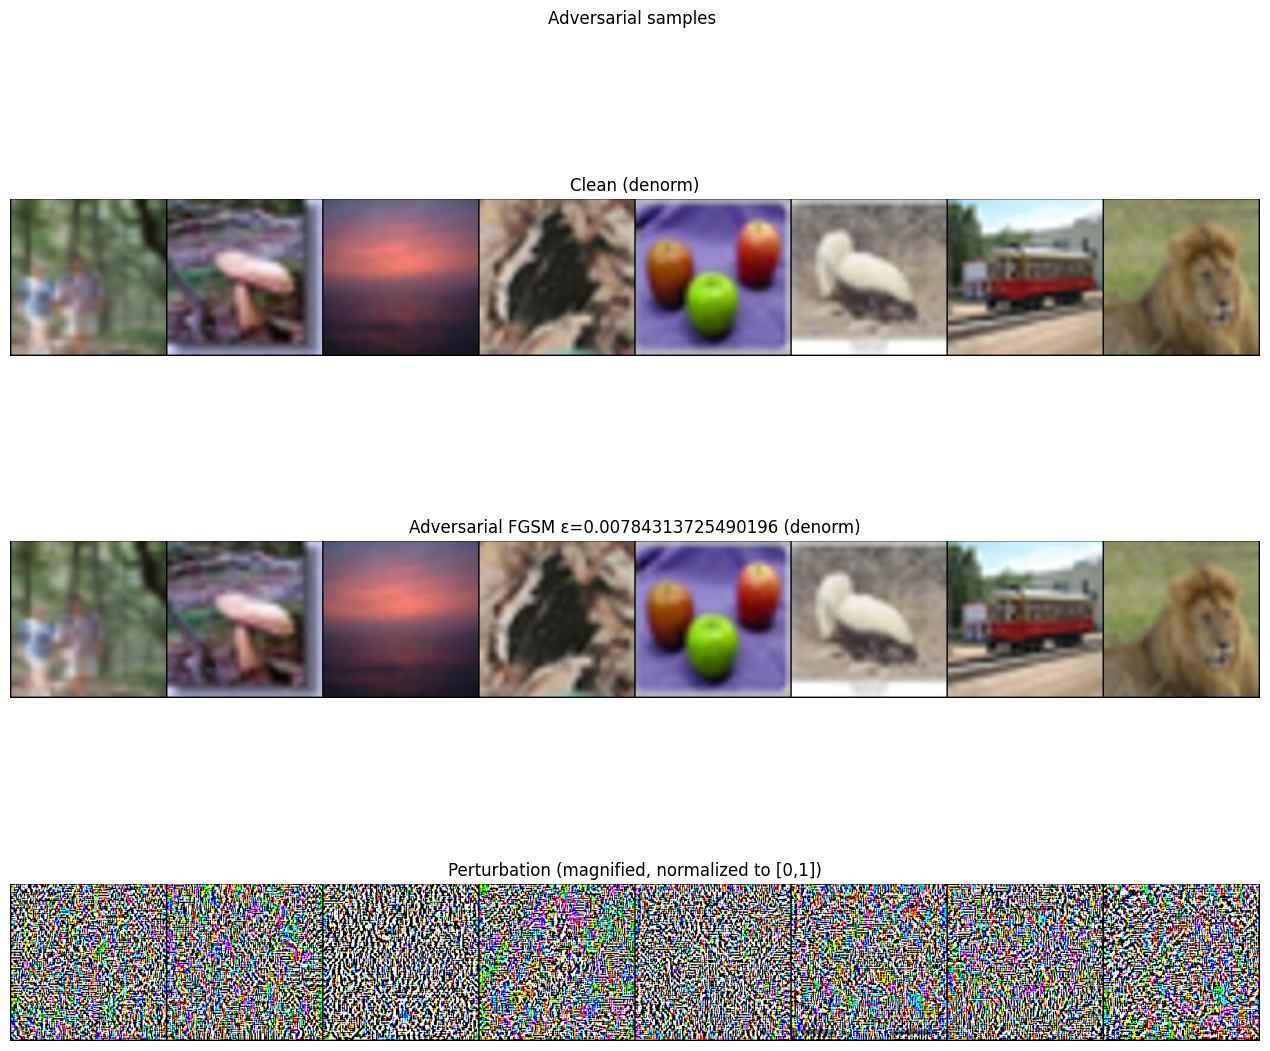

[0] GT: forest
    Baseline on CLEAN:  pred=forest               conf=0.999
    Baseline on ADV:    pred=willow_tree          conf=0.565 
    Adv-trained on ADV: pred=forest               conf=0.938
----------------------------------------------------------------------
[1] GT: mushroom
    Baseline on CLEAN:  pred=mushroom             conf=1.000
    Baseline on ADV:    pred=trout                conf=0.717 
    Adv-trained on ADV: pred=mushroom             conf=1.000
----------------------------------------------------------------------
[2] GT: sea
    Baseline on CLEAN:  pred=sea                  conf=0.930
    Baseline on ADV:    pred=cloud                conf=0.575 
    Adv-trained on ADV: pred=sea                  conf=0.828
----------------------------------------------------------------------
[3] GT: butterfly
    Baseline on CLEAN:  pred=butterfly            conf=0.969
    Baseline on ADV:    pred=skunk                conf=0.999 
    Adv-trained on ADV: pred=butterfly            

In [10]:
# --- helpers
def get_classes_from_loader(loader):
    ds = loader.dataset
    if hasattr(ds, "classes"): return ds.classes
    if hasattr(ds, "dataset") and hasattr(ds.dataset, "classes"): return ds.dataset.classes
    return [str(i) for i in range(100)]

classes = get_classes_from_loader(test_loader)

def preds_and_conf(model, x):
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = logits.softmax(dim=1)
        conf, pred = probs.max(dim=1)
    return pred, conf

def visualize_adv_batch(baseline, adv_model, loader, eps=2/255.0, kshow=8, title_suffix=""):
    device = next(baseline.parameters()).device
    images, targets = next(iter(loader))
    images = images.to(device)
    targets = to_hard(targets).to(device)

    # craft FGSM against the baseline (white-box)
    adv_images = fgsm_attack(baseline, images, targets, eps=eps)

    # predictions
    b_pred_clean, b_conf_clean = preds_and_conf(baseline, images)
    b_pred_adv,   b_conf_adv   = preds_and_conf(baseline, adv_images)
    a_pred_adv,   a_conf_adv   = preds_and_conf(adv_model, adv_images)

    # choose examples where baseline fails on adv but adv_model succeeds (nice for report)
    mask = (b_pred_adv != targets) & (a_pred_adv == targets)
    if mask.sum() == 0:
        print("No 'baseline fails, adv succeeds' in this batch; showing first k samples instead.")
        mask = torch.arange(min(kshow, images.size(0)), device=device)
    else:
        mask = torch.nonzero(mask).squeeze(1)[:kshow]

    imgs_clean = images[mask]
    imgs_adv   = adv_images[mask]
    y          = targets[mask]

    # perturbation (magnified for visibility)
    delta = (imgs_adv - imgs_clean)
    # scale delta to [-1,1] by max abs, then to [0,1] for visualization
    delta_vis = delta / (delta.abs().amax(dim=(1,2,3), keepdim=True) + 1e-12)
    delta_vis = (delta_vis + 1) / 2.0

    # build a 3-row grid: clean | adv | delta
    def to_grid(x):
        return make_grid(denorm(x).clamp(0,1).cpu(), nrow=len(x))
    grid_clean = to_grid(imgs_clean)
    grid_adv   = to_grid(imgs_adv)
    grid_delta = make_grid(delta_vis.cpu(), nrow=len(delta_vis))

    h = 4
    fig = plt.figure(figsize=(1.6*kshow, h*3))
    for i, (grid, ttl) in enumerate([
        (grid_clean, "Clean (denorm)"),
        (grid_adv,   f"Adversarial FGSM ε={eps} (denorm)"),
        (grid_delta, "Perturbation (magnified, normalized to [0,1])")
    ]):
        ax = fig.add_subplot(3,1,i+1)
        ax.imshow(grid.permute(1,2,0).numpy()); ax.axis("off"); ax.set_title(ttl)
    plt.suptitle(f"Adversarial samples {title_suffix}", y=0.995)
    plt.tight_layout()
    plt.show()

    # print per-sample captions with predictions/confidence
    b_pred_clean_s, b_conf_clean_s = b_pred_clean[mask], b_conf_clean[mask]
    b_pred_adv_s,   b_conf_adv_s   = b_pred_adv[mask],   b_conf_adv[mask]
    a_pred_adv_s,   a_conf_adv_s   = a_pred_adv[mask],   a_conf_adv[mask]

    for i in range(len(mask)):
        gt = classes[y[i].item()]
        bc = classes[b_pred_clean_s[i].item()]; bcc = b_conf_clean_s[i].item()
        ba = classes[b_pred_adv_s[i].item()];   bac = b_conf_adv_s[i].item()
        aa = classes[a_pred_adv_s[i].item()];   aac = a_conf_adv_s[i].item()
        print(f"[{i}] GT: {gt}")
        print(f"    Baseline on CLEAN:  pred={bc:20s} conf={bcc:.3f}")
        print(f"    Baseline on ADV:    pred={ba:20s} conf={bac:.3f} ")
        print(f"    Adv-trained on ADV: pred={aa:20s} conf={aac:.3f}")
        print("-"*70)

    # save images for report
    save_image(grid_clean, save_dir / f"advviz_clean_eps{eps:.6f}.png")
    save_image(grid_adv,   save_dir / f"advviz_adv_eps{eps:.6f}.png")
    save_image(grid_delta, save_dir / f"advviz_delta_eps{eps:.6f}.png")
    print("Saved:",
          save_dir / f"advviz_clean_eps{eps:.6f}.png",
          save_dir / f"advviz_adv_eps{eps:.6f}.png",
          save_dir / f"advviz_delta_eps{eps:.6f}.png")

visualize_adv_batch(baseline, adv_model, test_loader, eps=eps, kshow=kshow,
                    title_suffix="")


## Per-class accuracy: clean vs FGSM

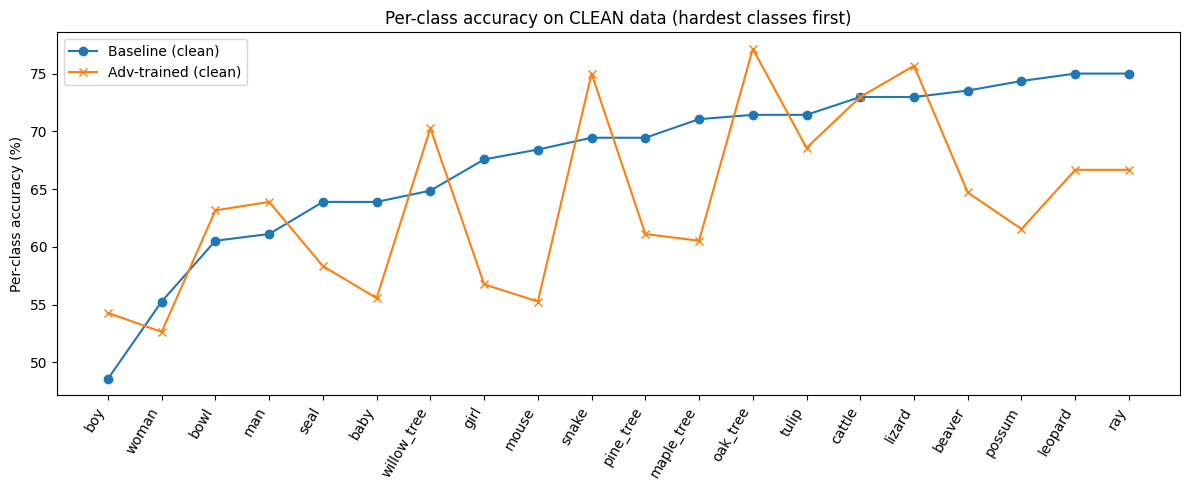

Overall mean (clean): baseline=84.21% | adv-trained=80.11%


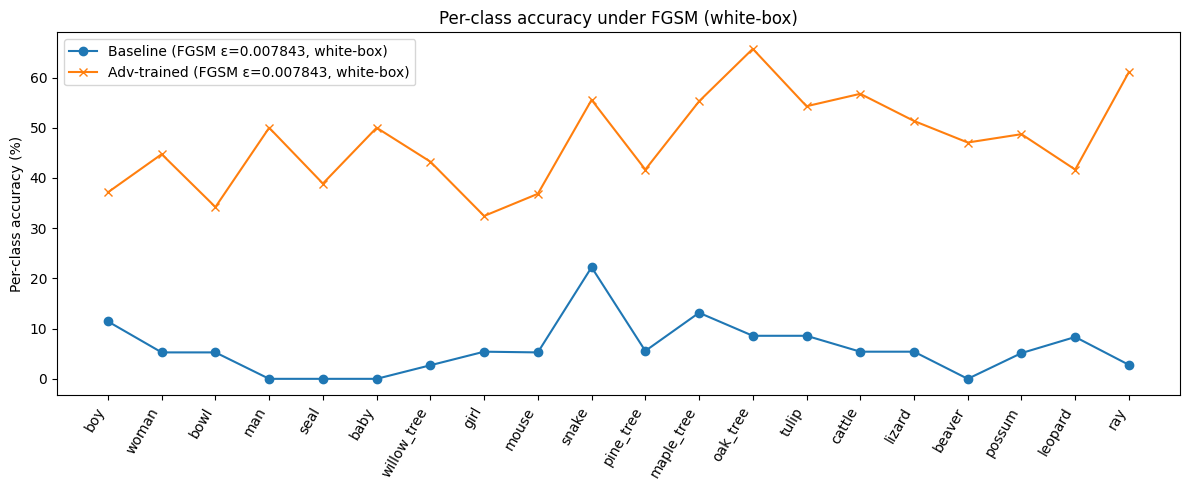

Overall mean (FGSM white-box ε=0.007843): baseline=20.70% | adv-trained=68.63%


In [ ]:
import numpy as np
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from attacks.fgsm import fgsm_attack
from utils.norm import to_hard

# ---- helpers
def per_class_acc(model, loader, eps=0.0, attacker=None):
    """
    Compute per-class accuracy.
    - model: model being evaluated
    - eps: FGSM epsilon; 0.0 means clean evaluation
    - attacker: None (clean) OR a callable(images, targets) -> adversarial_images
                Typically attacker will close over a crafting model, e.g. baseline or adv_model.
                If you want "white-box", pass attacker crafted on the *same* model.
    """
    model.eval()
    n_classes = 100
    correct = np.zeros(n_classes, dtype=np.int64)
    total   = np.zeros(n_classes, dtype=np.int64)

    for x, y in tqdm(loader, leave=False):
        y = to_hard(y)
        x, y = x.to(device), y.to(device)

        if eps > 0.0 and attacker is not None:
            x = attacker(x, y)  # craft with the provided attacker

        with torch.no_grad():
            pred = model(x).argmax(1)

        yi = y.cpu().numpy()
        pi = pred.cpu().numpy()
        total[yi]   += 1
        correct[yi] += (yi == pi)

    return (correct / total * 100.0), total

# ---- attackers
eps = 2/255.0

def make_whitebox_attacker(crafting_model, eps):
    def attacker(x, y):
        return fgsm_attack(crafting_model, x, y, eps=eps)
    return attacker

# White-box for each model (recommended fairness):
attacker_baseline_wb = make_whitebox_attacker(baseline,  eps)
attacker_adv_wb      = make_whitebox_attacker(adv_model, eps)

# (Optional) Transfer attack (craft on baseline for both models):
# attacker_transfer = make_whitebox_attacker(baseline, eps)

# ---- get class names from your loader
def get_class_names_from_loader(loader):
    ds = loader.dataset
    if hasattr(ds, "classes"): return ds.classes
    if hasattr(ds, "dataset") and hasattr(ds.dataset, "classes"): return ds.dataset.classes
    return [str(i) for i in range(100)]
classes = get_class_names_from_loader(test_loader)
names = np.array(classes)

# =============================
# 1) CLEAN: baseline vs adv
# =============================
pc_base_clean, _ = per_class_acc(baseline,  test_loader, eps=0.0, attacker=None)
pc_adv_clean,  _ = per_class_acc(adv_model, test_loader, eps=0.0, attacker=None)

# Sort classes by baseline clean accuracy (hardest first)
order = np.argsort(pc_base_clean)
kplot = 20   # show the hardest 20; change to 100 to show all
idxs  = order[:kplot]

plt.figure(figsize=(12,5))
plt.plot(range(kplot), pc_base_clean[idxs], marker='o', label="Baseline (clean)")
plt.plot(range(kplot), pc_adv_clean[idxs],  marker='x', label="Adv-trained (clean)")
plt.xticks(range(kplot), names[idxs], rotation=60, ha='right')
plt.ylabel("Per-class accuracy (%)")
plt.title("Per-class accuracy on CLEAN data (hardest classes first)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Overall mean (clean): baseline={pc_base_clean.mean():.2f}% | adv-trained={pc_adv_clean.mean():.2f}%")

# =============================
# 2) ADVERSARIAL (white-box): each model attacked by itself
# =============================
pc_base_adv, _ = per_class_acc(baseline,  test_loader, eps=eps, attacker=attacker_baseline_wb)
pc_adv_adv,  _ = per_class_acc(adv_model, test_loader, eps=eps, attacker=attacker_adv_wb)

# Use the SAME order (hardest clean for baseline) for consistent x-axis
plt.figure(figsize=(12,5))
plt.plot(range(kplot), pc_base_adv[idxs], marker='o', label=f"Baseline (FGSM ε={eps:.6f}, white-box)")
plt.plot(range(kplot), pc_adv_adv[idxs],  marker='x', label=f"Adv-trained (FGSM ε={eps:.6f}, white-box)")
plt.xticks(range(kplot), names[idxs], rotation=60, ha='right')
plt.ylabel("Per-class accuracy (%)")
plt.title("Per-class accuracy under FGSM (white-box)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Overall mean (FGSM white-box ε={eps:.6f}): baseline={pc_base_adv.mean():.2f}% | adv-trained={pc_adv_adv.mean():.2f}%")